# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install Package
!pip install geemap
!pip install rasterio
!pip install rasterstats
!pip install geopandas
!pip install shapely


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.2 MB/s eta 0:00:00


#Preprocessing

### Clip Raster

In [ ]:
import rasterio
import rasterio.mask
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm
import numpy as np
import os

# Load shapefile kota
shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
geom_kota = gpd.read_file(shapefile_path)
list_kota = geom_kota['fid'].unique()

# Load file TIFF yang akan dipotong
tiff_file = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Citra Malam/CItra Lampung 2021/LPG-Raster average_masked2021.tif'

# Menyiapkan directory untuk menyimpan hasil
hasil_dir = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Output Desa'
if not os.path.exists(hasil_dir):
    os.makedirs(hasil_dir)

# Menyiapkan list untuk menyimpan hasil potongan
potongan_tif = []

# Loop untuk setiap kota
for kota_id in tqdm(list_kota):
    with rasterio.open(tiff_file) as src:
        # Ambil geometri kota dengan kota_id tertentu
        shapes = geom_kota.query(f'fid == {kota_id}').geometry

        # Pastikan shapes tidak kosong dan hanya mengambil geometri pertama jika MultiPolygon
        if not shapes.empty:
            # Memeriksa tipe geometri dan memilih geometri yang tepat
            if isinstance(shapes.iloc[0], Polygon):
                shape_to_use = shapes.iloc[0]
            elif isinstance(shapes.iloc[0], MultiPolygon):
                # Ambil salah satu bagian dari MultiPolygon (misalnya, yang pertama)
                shape_to_use = shapes.iloc[0].geoms[0]
            else:
                print(f"Warning: Unknown geometry type for Kota ID {kota_id}")
                continue

            # Lakukan pemotongan dengan geometri yang dipilih
            out_image, out_transform = rasterio.mask.mask(
                src, [shape_to_use], crop=True, all_touched=True, filled=True, nodata=np.nan
            )

            # Update metadata
            out_meta = src.meta
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            # Simpan hasil potongan ke file
            output_filename = os.path.join(hasil_dir, f"{kota_id}_clip.tif")
            with rasterio.open(output_filename, "w", **out_meta) as dest:
                dest.write(out_image)

            # Tambahkan informasi potongan ke dalam list
            potongan_tif.append({'kota_id': kota_id, 'image': out_image})
        else:
            print(f"Warning: No geometry found for Kota ID {kota_id}")

# Konversi hasil potongan ke DataFrame
dfdesa = pd.DataFrame(potongan_tif)
dfdesa

## Kalkulasi Raster

In [ ]:
import rasterio
import rasterio.mask
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

# Load shapefile kota
shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
geom_kota = gpd.read_file(shapefile_path)
list_kota = geom_kota['fid'].unique()

# Load file TIFF yang akan dipotong
tiff_file = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Citra Malam/CItra Lampung 2021/LPG-Raster average_masked2021.tif'

# Menyiapkan dictionary untuk menyimpan hasil potongan
potongan_tif = []

for kota_id in tqdm(list_kota):
    with rasterio.open(tiff_file) as src:
        shapes = geom_kota.query(f'fid == {kota_id}').geometry
        if shapes.is_empty.any() or shapes.isnull().any():
            print(f"Skipping kota_id {kota_id} due to invalid geometry.")
            continue
        out_image, out_transform = rasterio.mask.mask(
            src, shapes, crop=True, all_touched=True, filled=True, nodata=np.nan
        )
        # Mengambil nilai pixel sebagai array 1D
        pixel_values = out_image[0].flatten()

        # Menyimpan hasil potongan dalam dictionary
        potongan_tif.append({
            'kota_id': kota_id,
            'mean': np.nanmean(pixel_values),
            'median': np.nanmedian(pixel_values),# Contoh statistik, bisa disesuaikan
            'min': np.nanmin(pixel_values),
            'max': np.nanmax(pixel_values),
            'std': np.nanstd(pixel_values)
        })

# Mengonversi hasil potongan ke DataFrame
desa = pd.DataFrame(potongan_tif)
desa

In [ ]:
desa.rename(columns={'kota_id': 'desa'}, inplace=True)
desa

,desa,mean,median,min,max,std
0,21.0,0.822417,0.864656,0.000000,2.643538,0.677254
1,22.0,1.926651,1.080812,0.000000,6.180604,1.840735
2,36.0,1.611473,1.277627,0.000000,6.079782,1.311369
3,75.0,0.397667,0.000000,0.000000,1.295707,0.496313
4,83.0,1.699605,1.250731,0.000000,6.180604,1.509303
...,...,...,...,...,...,...
251,2588.0,1.132790,1.211768,0.000000,1.625161,0.366905
252,2594.0,0.604027,0.661965,0.000000,1.955859,0.536790
253,2608.0,0.575528,0.588379,0.000000,2.072246,0.582334
254,2670.0,5.189648,4.092315,1.066605,15.338837,4.075399


In [ ]:
desa2= desa.rename(columns={'kota_id':'desa'})
desa2

,desa,mean,median,min,max,std
0,21.0,0.822417,0.864656,0.000000,2.643538,0.677254
1,22.0,1.926651,1.080812,0.000000,6.180604,1.840735
2,36.0,1.611473,1.277627,0.000000,6.079782,1.311369
3,75.0,0.397667,0.000000,0.000000,1.295707,0.496313
4,83.0,1.699605,1.250731,0.000000,6.180604,1.509303
...,...,...,...,...,...,...
251,2588.0,1.132790,1.211768,0.000000,1.625161,0.366905
252,2594.0,0.604027,0.661965,0.000000,1.955859,0.536790
253,2608.0,0.575528,0.588379,0.000000,2.072246,0.582334
254,2670.0,5.189648,4.092315,1.066605,15.338837,4.075399


In [ ]:
gs = gpd.read_file('/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp')
gs=gs[gs['WADMPR'] == 'Lampung']
gs=gs[gs['WADMKK'] == 'Lampung Selatan']
gs= gs.rename(columns={'fid':'desa'})
gs

,desa,OBJECTID,NAMOBJ,FCODE,REMARK,METADATA,SRS_ID,KDBBPS,KDCBPS,KDCPUM,...,WADMKD,WADMKK,WADMPR,WIADKC,WIADKK,WIADPR,WIADKD,UUPP,LUAS,geometry
0,21.0,95569.0,Babatan,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.08,...,Babatan,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,844.517042,"POLYGON Z ((105.41549 -5.55432 0.00000, 105.41..."
1,22.0,95570.0,Babulang,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.06,...,Babulang,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,209.008367,"POLYGON Z ((105.62622 -5.73364 0.00000, 105.62..."
2,36.0,95671.0,Agom,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.06,...,Agom,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,751.177934,"POLYGON Z ((105.60096 -5.63715 0.00000, 105.60..."
3,75.0,97332.0,Mekar Jaya,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.18,...,Mekar Jaya,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,1300.122473,"POLYGON Z ((105.41373 -5.50301 0.00000, 105.41..."
4,83.0,97340.0,Negeri Pandan,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.06,...,Negeri Pandan,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,773.815930,"POLYGON Z ((105.65553 -5.68685 0.00000, 105.65..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2585.0,97275.0,Panca Tunggal,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.18,...,Panca Tunggal,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,1296.590679,"POLYGON Z ((105.47341 -5.43836 0.00000, 105.47..."
252,2588.0,97278.0,Pancasila,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.04,...,Pancasila,Lampung Selatan,Lampung,None,None,None,None,Hasil Kegiatan PNBP Tahun 2016,523.218968,"POLYGON Z ((105.27935 -5.24094 0.00000, 105.27..."
253,2594.0,97284.0,Purwodadi Dalam,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.22,...,Purwodadi Dalam,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,2232.731083,"POLYGON Z ((105.44723 -5.34994 0.00000, 105.44..."
254,2608.0,97298.0,Purwodadi Simpang,BA03070040,None,TASWIL1000020230928_DATA_BATAS_DESAKELURAHAN,SRGI 2013,None,None,18.01.05,...,Purwodadi Simpang,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,1265.904271,"POLYGON Z ((105.43711 -5.32608 0.00000, 105.43..."


In [ ]:
desa2= pd.merge(desa2, gs, on='desa')
desa2

,desa,mean,median,min,max,std,OBJECTID,NAMOBJ,FCODE,REMARK,...,WADMKD,WADMKK,WADMPR,WIADKC,WIADKK,WIADPR,WIADKD,UUPP,LUAS,geometry
0,21.0,0.822417,0.864656,0.000000,2.643538,0.677254,95569.0,Babatan,BA03070040,None,...,Babatan,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,844.517042,"POLYGON Z ((105.41549 -5.55432 0.00000, 105.41..."
1,22.0,1.926651,1.080812,0.000000,6.180604,1.840735,95570.0,Babulang,BA03070040,None,...,Babulang,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,209.008367,"POLYGON Z ((105.62622 -5.73364 0.00000, 105.62..."
2,36.0,1.611473,1.277627,0.000000,6.079782,1.311369,95671.0,Agom,BA03070040,None,...,Agom,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,751.177934,"POLYGON Z ((105.60096 -5.63715 0.00000, 105.60..."
3,75.0,0.397667,0.000000,0.000000,1.295707,0.496313,97332.0,Mekar Jaya,BA03070040,None,...,Mekar Jaya,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,1300.122473,"POLYGON Z ((105.41373 -5.50301 0.00000, 105.41..."
4,83.0,1.699605,1.250731,0.000000,6.180604,1.509303,97340.0,Negeri Pandan,BA03070040,None,...,Negeri Pandan,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,773.815930,"POLYGON Z ((105.65553 -5.68685 0.00000, 105.65..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2588.0,1.132790,1.211768,0.000000,1.625161,0.366905,97278.0,Pancasila,BA03070040,None,...,Pancasila,Lampung Selatan,Lampung,None,None,None,None,Hasil Kegiatan PNBP Tahun 2016,523.218968,"POLYGON Z ((105.27935 -5.24094 0.00000, 105.27..."
252,2594.0,0.604027,0.661965,0.000000,1.955859,0.536790,97284.0,Purwodadi Dalam,BA03070040,None,...,Purwodadi Dalam,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,2232.731083,"POLYGON Z ((105.44723 -5.34994 0.00000, 105.44..."
253,2608.0,0.575528,0.588379,0.000000,2.072246,0.582334,97298.0,Purwodadi Simpang,BA03070040,None,...,Purwodadi Simpang,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,1265.904271,"POLYGON Z ((105.43711 -5.32608 0.00000, 105.43..."
254,2670.0,5.189648,4.092315,1.066605,15.338837,4.075399,100357.0,Rawi,BA03070040,None,...,Rawi,Lampung Selatan,Lampung,None,None,None,None,Hasil Delineasi Batas Desa 2017,156.979259,"POLYGON Z ((105.65456 -5.73631 0.00000, 105.65..."


In [ ]:
desa2=desa2[['desa', 'NAMOBJ','WADMKK','mean','median','min','max','std','LUAS']]
desa2=desa2.rename(columns={'desa':'id_desa','NAMOBJ':'desa','WADMKK':'Kabupaten/Kota'})
desa2['id_desa'] = desa2['id_desa'].astype(str)
desa2

,id_desa,desa,Kabupaten/Kota,mean,median,min,max,std,LUAS
0,21.0,Babatan,Lampung Selatan,0.822417,0.864656,0.000000,2.643538,0.677254,844.517042
1,22.0,Babulang,Lampung Selatan,1.926651,1.080812,0.000000,6.180604,1.840735,209.008367
2,36.0,Agom,Lampung Selatan,1.611473,1.277627,0.000000,6.079782,1.311369,751.177934
3,75.0,Mekar Jaya,Lampung Selatan,0.397667,0.000000,0.000000,1.295707,0.496313,1300.122473
4,83.0,Negeri Pandan,Lampung Selatan,1.699605,1.250731,0.000000,6.180604,1.509303,773.815930
...,...,...,...,...,...,...,...,...,...
251,2588.0,Pancasila,Lampung Selatan,1.132790,1.211768,0.000000,1.625161,0.366905,523.218968
252,2594.0,Purwodadi Dalam,Lampung Selatan,0.604027,0.661965,0.000000,1.955859,0.536790,2232.731083
253,2608.0,Purwodadi Simpang,Lampung Selatan,0.575528,0.588379,0.000000,2.072246,0.582334,1265.904271
254,2670.0,Rawi,Lampung Selatan,5.189648,4.092315,1.066605,15.338837,4.075399,156.979259


In [ ]:
desa2

,id_desa,desa,Kabupaten/Kota,mean,median,min,max,std,LUAS
0,21.0,Babatan,Lampung Selatan,0.822417,0.864656,0.000000,2.643538,0.677254,844.517042
1,22.0,Babulang,Lampung Selatan,1.926651,1.080812,0.000000,6.180604,1.840735,209.008367
2,36.0,Agom,Lampung Selatan,1.611473,1.277627,0.000000,6.079782,1.311369,751.177934
3,75.0,Mekar Jaya,Lampung Selatan,0.397667,0.000000,0.000000,1.295707,0.496313,1300.122473
4,83.0,Negeri Pandan,Lampung Selatan,1.699605,1.250731,0.000000,6.180604,1.509303,773.815930
...,...,...,...,...,...,...,...,...,...
251,2588.0,Pancasila,Lampung Selatan,1.132790,1.211768,0.000000,1.625161,0.366905,523.218968
252,2594.0,Purwodadi Dalam,Lampung Selatan,0.604027,0.661965,0.000000,1.955859,0.536790,2232.731083
253,2608.0,Purwodadi Simpang,Lampung Selatan,0.575528,0.588379,0.000000,2.072246,0.582334,1265.904271
254,2670.0,Rawi,Lampung Selatan,5.189648,4.092315,1.066605,15.338837,4.075399,156.979259


## Data Preparation

## Data Intensitas Cahaya & Luas

In [ ]:
desa2= desa2.sort_values('desa')
desa2['id'] = range(1, len(desa2) + 1)
desa2

,id_desa,desa,Kabupaten/Kota,mean,median,min,max,std,LUAS,id
2,36.0,Agom,Lampung Selatan,1.611473,1.277627,0.000000,6.079782,1.311369,751.177934,1
0,21.0,Babatan,Lampung Selatan,0.822417,0.864656,0.000000,2.643538,0.677254,844.517042,2
1,22.0,Babulang,Lampung Selatan,1.926651,1.080812,0.000000,6.180604,1.840735,209.008367,3
152,1665.0,Bakauheni,Lampung Selatan,1.930894,1.047473,0.000000,19.531267,2.986455,1628.107093,4
153,1668.0,Baktirasa,Lampung Selatan,0.765485,0.879174,0.000000,1.838886,0.505196,774.231366,5
...,...,...,...,...,...,...,...,...,...,...
91,920.0,Way Gelam,Lampung Selatan,0.657963,0.695861,0.000000,1.247996,0.368268,498.391442,252
93,966.0,Way Hui,Lampung Selatan,10.121570,10.396008,4.064504,17.722128,3.496055,578.206824,253
96,998.0,Way Kalam,Lampung Selatan,0.416636,0.000000,0.000000,1.597839,0.471098,794.913418,254
85,837.0,Way Muli,Lampung Selatan,0.434928,0.000000,0.000000,3.109931,0.657623,488.479376,255


### Data Ketinggian Desa

In [ ]:
tinggi= pd.read_csv("/content/drive/MyDrive/Model Citra Malam Kemiskinan/KetinggianDesaLamsel.csv")
tinggi= tinggi.drop(tinggi.columns[0], axis=1)
tinggi = tinggi.rename(columns={'NAMOBJ': 'desa'})
tinggi= tinggi.sort_values('desa')
tinggi['id'] = range(1, len(tinggi) + 1)
tinggi

,desa,ketinggian(m),id
2,Agom,14.266709,1
0,Babatan,170.383996,2
1,Babulang,303.360072,3
153,Bakauheni,59.582633,4
154,Baktirasa,14.169109,5
...,...,...,...
92,Way Gelam,21.878081,252
94,Way Hui,103.086131,253
97,Way Kalam,535.691475,254
86,Way Muli,443.016828,255


### Data Jumlah Bangunan

In [ ]:
jml= pd.read_csv("/content/drive/MyDrive/Model Citra Malam Kemiskinan/jumlahbangunanperdesaLamsel.csv")
jml= jml.sort_values('desa')
jml['id'] = range(1, len(jml) + 1)
jml

,desa,jumlah bangunan,id
17,Agom,6217,1
57,Babatan,1801,2
16,Babulang,20,3
186,Bakauheni,20900,4
134,Baktirasa,4550,5
...,...,...,...
162,Way Gelam,4851,252
237,Way Hui,11502,253
73,Way Kalam,717,254
140,Way Muli,1926,255


### Data IKG di Lampung Selatan

In [ ]:
ikg= pd.read_excel("/content/drive/MyDrive/Model Citra Malam Kemiskinan/IKG 2021 Lampung Selatan.xlsx")
ikg= ikg.drop(ikg.columns[0], axis=1)
ikg = ikg.rename(columns={'Desa': 'desa'})
ikg= ikg.sort_values('desa')
ikg['id'] = range(1, len(ikg) + 1)
ikg

,ID Desa Podes 2021,Provinsi Podes 2021,Kabupaten Podes 2021,Kecamatan Podes 2021,Nama Desa Podes 2021,ID Desa Kepmen,Nama Desa Kepmen,Nama Provinsi Kepmen,Nama Kabupaten Kepmen,Nama Kecamatan Kepmen,desa,Dimensi Pelayanan Dasar,Dimensi Infrastruktur,Dimensi Aksesbilitas,IKG 2021,id
161,1803110040,Lampung,Lampung Selatan,Kalianda,Agom,1801062025,AGOM,LAMPUNG,LAMPUNG SELATAN,Kalianda,Agom,18.887905,57.473907,22.730706,28.712429,1
73,1803090003,Lampung,Lampung Selatan,Katibung,Babatan,1801082002,BABATAN,LAMPUNG,LAMPUNG SELATAN,Katibung,Babatan,24.497551,42.345784,5.725124,22.754355,2
149,1803110027,Lampung,Lampung Selatan,Kalianda,Babulang,1801062013,BABULANG,LAMPUNG,LAMPUNG SELATAN,Kalianda,Babulang,36.115101,54.817153,4.234053,30.552478,3
253,1803132003,Lampung,Lampung Selatan,Bakauheni,Bakauheni,1801212004,BAKAUHENI,LAMPUNG,LAMPUNG SELATAN,Bakauheni,Bakauheni,23.713183,13.560800,4.234053,15.477637,4
202,1803121001,Lampung,Lampung Selatan,Sragi,Bakti Rasa,1801152002,BAKTIRASA,LAMPUNG,LAMPUNG SELATAN,Sragi,Baktirasa,24.497551,43.183817,17.005582,26.393639,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1803101003,Lampung,Lampung Selatan,Candipuro,Way Gelam,1801172005,WAY GELAM,LAMPUNG,LAMPUNG SELATAN,Candipuro,Way Gelam,42.469189,54.817153,17.005582,37.445871,252
26,1803070001,Lampung,Lampung Selatan,Jati Agung,Way Huwi,1801132001,WAY HUI,LAMPUNG,LAMPUNG SELATAN,Jati Agung,Way Hui,26.507941,49.503646,18.496653,29.211062,253
220,1803130021,Lampung,Lampung Selatan,Penengahan,Way Kalam,1801092013,WAY KALAM,LAMPUNG,LAMPUNG SELATAN,Penengahan,Way Kalam,39.367292,54.817153,21.239635,37.283797,254
171,1803111007,Lampung,Lampung Selatan,Rajabasa,Waymuli,1801162015,WAY MULI,LAMPUNG,LAMPUNG SELATAN,Raja Basa,Way Muli,24.348391,57.473907,18.496653,29.982782,255


### Merge

In [ ]:
df_merged = pd.merge(desa2, jml, on='id')
df_merged = pd.merge(df_merged, ikg, on='id')
datamodel= pd.merge(df_merged, tinggi, on='id', suffixes=('_merged', '_tinggi'))  # Add suffixes to avoid duplicate column names
datamodel

,id_desa,desa_x,Kabupaten/Kota,mean,median,min,max,std,LUAS,id,...,Nama Provinsi Kepmen,Nama Kabupaten Kepmen,Nama Kecamatan Kepmen,desa_merged,Dimensi Pelayanan Dasar,Dimensi Infrastruktur,Dimensi Aksesbilitas,IKG 2021,desa_tinggi,ketinggian(m)
0,36.0,Agom,Lampung Selatan,1.611473,1.277627,0.000000,6.079782,1.311369,751.177934,1,...,LAMPUNG,LAMPUNG SELATAN,Kalianda,Agom,18.887905,57.473907,22.730706,28.712429,Agom,14.266709
1,21.0,Babatan,Lampung Selatan,0.822417,0.864656,0.000000,2.643538,0.677254,844.517042,2,...,LAMPUNG,LAMPUNG SELATAN,Katibung,Babatan,24.497551,42.345784,5.725124,22.754355,Babatan,170.383996
2,22.0,Babulang,Lampung Selatan,1.926651,1.080812,0.000000,6.180604,1.840735,209.008367,3,...,LAMPUNG,LAMPUNG SELATAN,Kalianda,Babulang,36.115101,54.817153,4.234053,30.552478,Babulang,303.360072
3,1665.0,Bakauheni,Lampung Selatan,1.930894,1.047473,0.000000,19.531267,2.986455,1628.107093,4,...,LAMPUNG,LAMPUNG SELATAN,Bakauheni,Bakauheni,23.713183,13.560800,4.234053,15.477637,Bakauheni,59.582633
4,1668.0,Baktirasa,Lampung Selatan,0.765485,0.879174,0.000000,1.838886,0.505196,774.231366,5,...,LAMPUNG,LAMPUNG SELATAN,Sragi,Baktirasa,24.497551,43.183817,17.005582,26.393639,Baktirasa,14.169109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,920.0,Way Gelam,Lampung Selatan,0.657963,0.695861,0.000000,1.247996,0.368268,498.391442,252,...,LAMPUNG,LAMPUNG SELATAN,Candipuro,Way Gelam,42.469189,54.817153,17.005582,37.445871,Way Gelam,21.878081
252,966.0,Way Hui,Lampung Selatan,10.121570,10.396008,4.064504,17.722128,3.496055,578.206824,253,...,LAMPUNG,LAMPUNG SELATAN,Jati Agung,Way Hui,26.507941,49.503646,18.496653,29.211062,Way Hui,103.086131
253,998.0,Way Kalam,Lampung Selatan,0.416636,0.000000,0.000000,1.597839,0.471098,794.913418,254,...,LAMPUNG,LAMPUNG SELATAN,Penengahan,Way Kalam,39.367292,54.817153,21.239635,37.283797,Way Kalam,535.691475
254,837.0,Way Muli,Lampung Selatan,0.434928,0.000000,0.000000,3.109931,0.657623,488.479376,255,...,LAMPUNG,LAMPUNG SELATAN,Raja Basa,Way Muli,24.348391,57.473907,18.496653,29.982782,Way Muli,443.016828


In [ ]:
datamodel= datamodel.drop(columns=['id_desa', 'desa_x', 'Kabupaten/Kota','desa_y',
       'ID Desa Podes 2021', 'Provinsi Podes 2021', 'Kabupaten Podes 2021',
       'Kecamatan Podes 2021', 'Nama Desa Podes 2021', 'ID Desa Kepmen',
       'Nama Desa Kepmen', 'Nama Provinsi Kepmen', 'Nama Kabupaten Kepmen',
                                   'desa_merged', 'Dimensi Pelayanan Dasar',
       'Dimensi Infrastruktur', 'Dimensi Aksesbilitas','id', 'median','min',	'max',	'std', 'Nama Kecamatan Kepmen'])
datamodel = datamodel.rename(columns={'desa_tinggi': 'desa'})
datamodel

,mean,LUAS,jumlah bangunan,IKG 2021,desa,ketinggian(m)
0,1.611473,751.177934,6217,28.712429,Agom,14.266709
1,0.822417,844.517042,1801,22.754355,Babatan,170.383996
2,1.926651,209.008367,20,30.552478,Babulang,303.360072
3,1.930894,1628.107093,20900,15.477637,Bakauheni,59.582633
4,0.765485,774.231366,4550,26.393639,Baktirasa,14.169109
...,...,...,...,...,...,...
251,0.657963,498.391442,4851,37.445871,Way Gelam,21.878081
252,10.121570,578.206824,11502,29.211062,Way Hui,103.086131
253,0.416636,794.913418,717,37.283797,Way Kalam,535.691475
254,0.434928,488.479376,1926,29.982782,Way Muli,443.016828


##Transformasi Data



In [ ]:
datamodel

,mean,LUAS,jumlah bangunan,IKG 2021,desa,ketinggian(m)
0,1.611473,751.177934,6217,28.712429,Agom,14.266709
1,0.822417,844.517042,1801,22.754355,Babatan,170.383996
2,1.926651,209.008367,20,30.552478,Babulang,303.360072
3,1.930894,1628.107093,20900,15.477637,Bakauheni,59.582633
4,0.765485,774.231366,4550,26.393639,Baktirasa,14.169109
...,...,...,...,...,...,...
251,0.657963,498.391442,4851,37.445871,Way Gelam,21.878081
252,10.121570,578.206824,11502,29.211062,Way Hui,103.086131
253,0.416636,794.913418,717,37.283797,Way Kalam,535.691475
254,0.434928,488.479376,1926,29.982782,Way Muli,443.016828


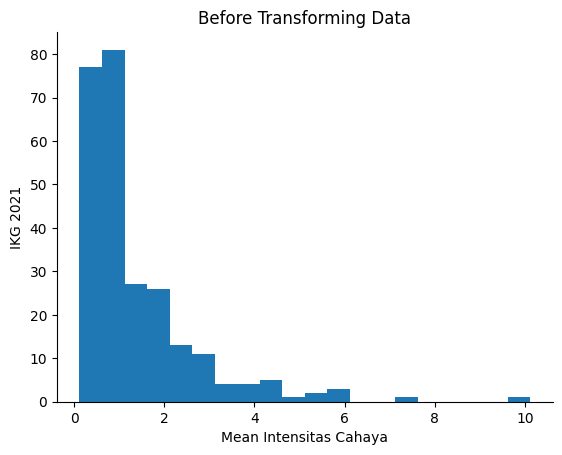

In [ ]:
from matplotlib import pyplot as plt
datamodel['mean'].plot(kind='hist', bins=20, title='Before Transforming Data')
plt.title('Before Transforming Data')
plt.ylabel('IKG 2021')
plt.xlabel('Mean Intensitas Cahaya')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def log_transform_data(desa2, cols_to_transform):
  """
  Applies log(x+1) transformation to specified numerical columns in a DataFrame.

  Args:
      data (pandas.DataFrame): The DataFrame containing the data.
      cols_to_transform (list): A list of column names to transform.

  Returns:
      pandas.DataFrame: The DataFrame with transformed columns.
  """

  if not isinstance(datamodel, pd.DataFrame):
    raise TypeError("Input data must be a pandas.DataFrame")

  if not all(col in datamodel.columns for col in cols_to_transform):
    raise ValueError(f"Columns {', '.join(set(cols_to_transform) - set(desa2.columns))} not found in data")

  data_to_transform = datamodel[cols_to_transform]

  transformed_data = data_to_transform.apply(lambda x: np.log1p(x+1))

  return pd.concat([datamodel.drop(cols_to_transform, axis=1), transformed_data], axis=1)
cols_to_transform = ['mean'] # 'median', 'max', 'min', 'std'
datamodel= log_transform_data(datamodel.copy(), cols_to_transform)
datamodel

,LUAS,jumlah bangunan,IKG 2021,desa,ketinggian(m),mean
0,751.177934,6217,28.712429,Agom,14.266709,1.284116
1,844.517042,1801,22.754355,Babatan,170.383996,1.037593
2,209.008367,20,30.552478,Babulang,303.360072,1.367787
3,1628.107093,20900,15.477637,Bakauheni,59.582633,1.368867
4,774.231366,4550,26.393639,Baktirasa,14.169109,1.017216
...,...,...,...,...,...,...
251,498.391442,4851,37.445871,Way Gelam,21.878081,0.977560
252,578.206824,11502,29.211062,Way Hui,103.086131,2.494986
253,794.913418,717,37.283797,Way Kalam,535.691475,0.882377
254,488.479376,1926,29.982782,Way Muli,443.016828,0.889917


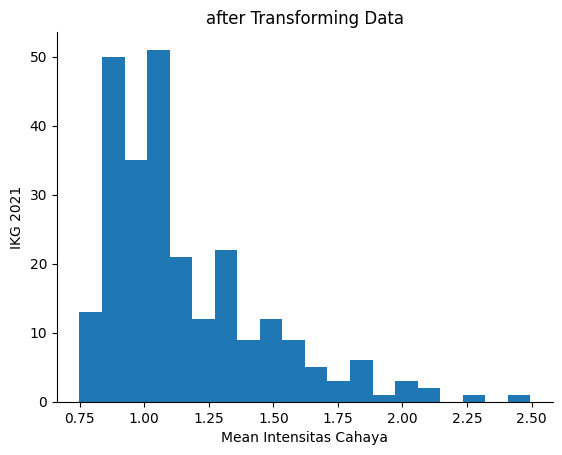

In [ ]:
import matplotlib.pyplot as plt

datamodel['mean'].plot(kind='hist', bins=20, title='after Transforming Data')
plt.title('after Transforming Data')
plt.ylabel('IKG 2021')
plt.xlabel('Mean Intensitas Cahaya')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

## Export Excel (Data Kalkulasi Raster)

In [ ]:
datadesa.to_excel('KalkulasiRasterLMSEL.xlsx',index=False)

## Peta

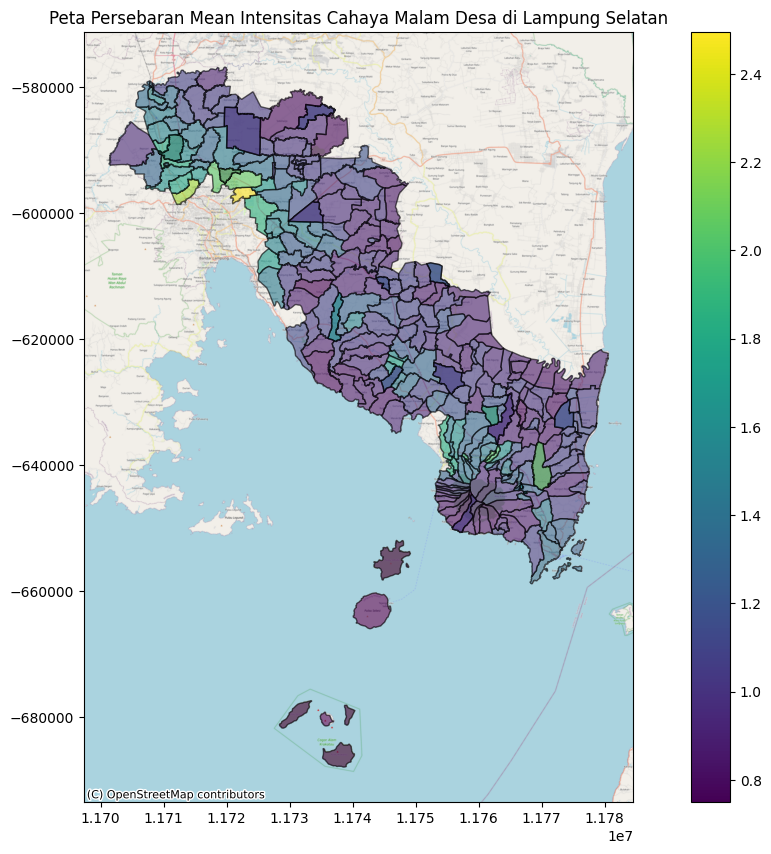

In [ ]:
!pip install contextily
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Path ke shapefile
shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.merge(datamodel, left_on='NAMOBJ', right_on='desa')
gdf = gdf.to_crs(epsg=3857)

# Membuat plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='mean', ax=ax, legend=True, cmap='viridis', edgecolor='black', alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Peta Persebaran Mean Intensitas Cahaya Malam Desa di Lampung Selatan')
plt.show()


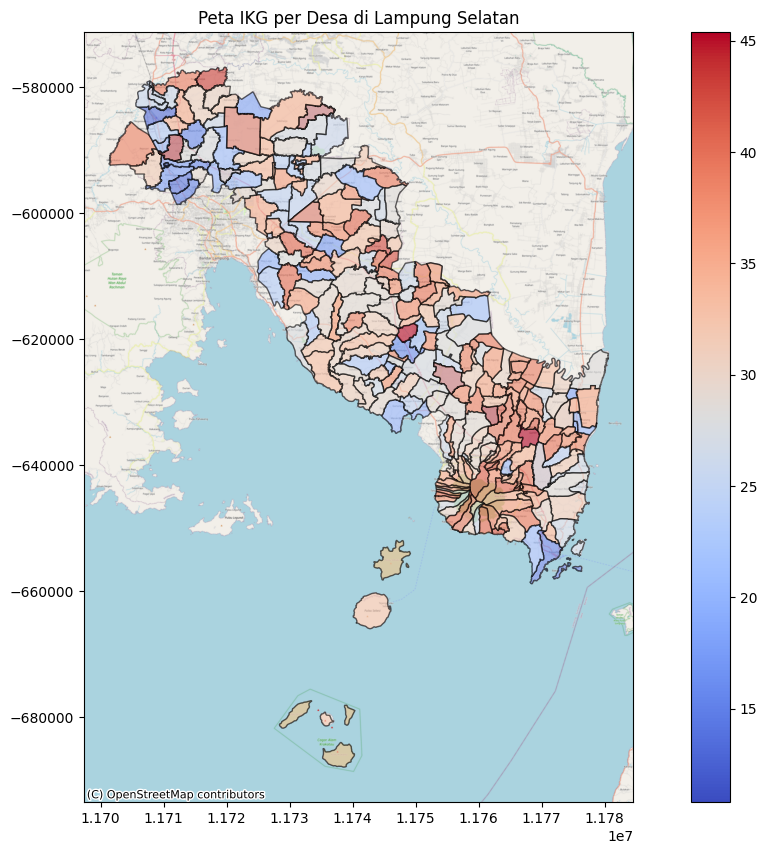

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.merge(datamodel, left_on='NAMOBJ', right_on='desa')
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='IKG 2021', ax=ax, legend=True, cmap='coolwarm', edgecolor='black', alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Peta IKG per Desa di Lampung Selatan')
plt.show()

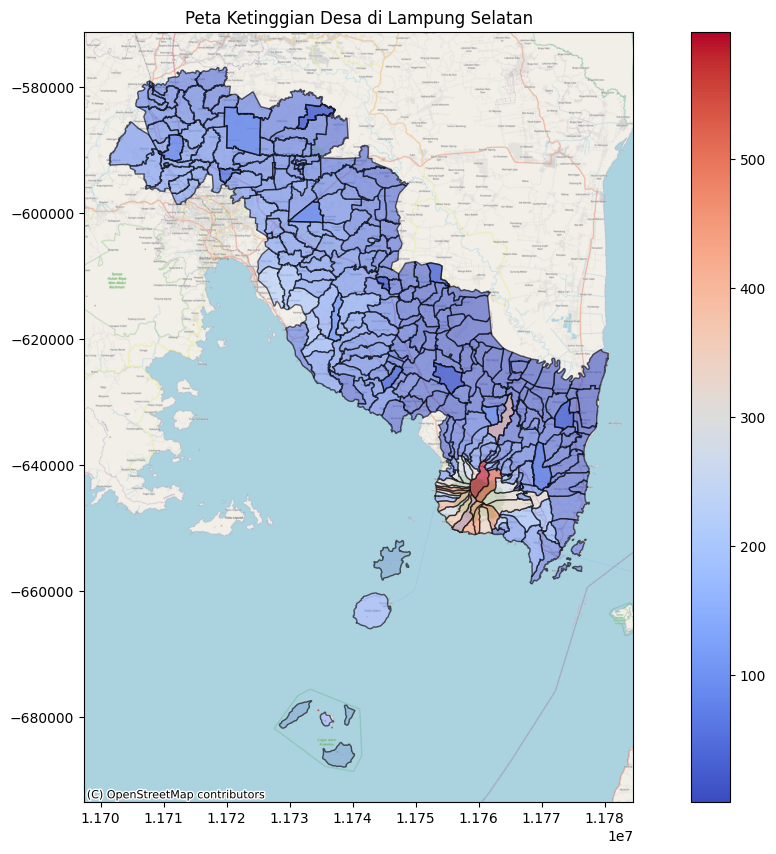

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.merge(datamodel, left_on='NAMOBJ', right_on='desa')
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='ketinggian(m)', ax=ax, legend=True, cmap='coolwarm', edgecolor='black', alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Peta Ketinggian Desa di Lampung Selatan')
plt.show()

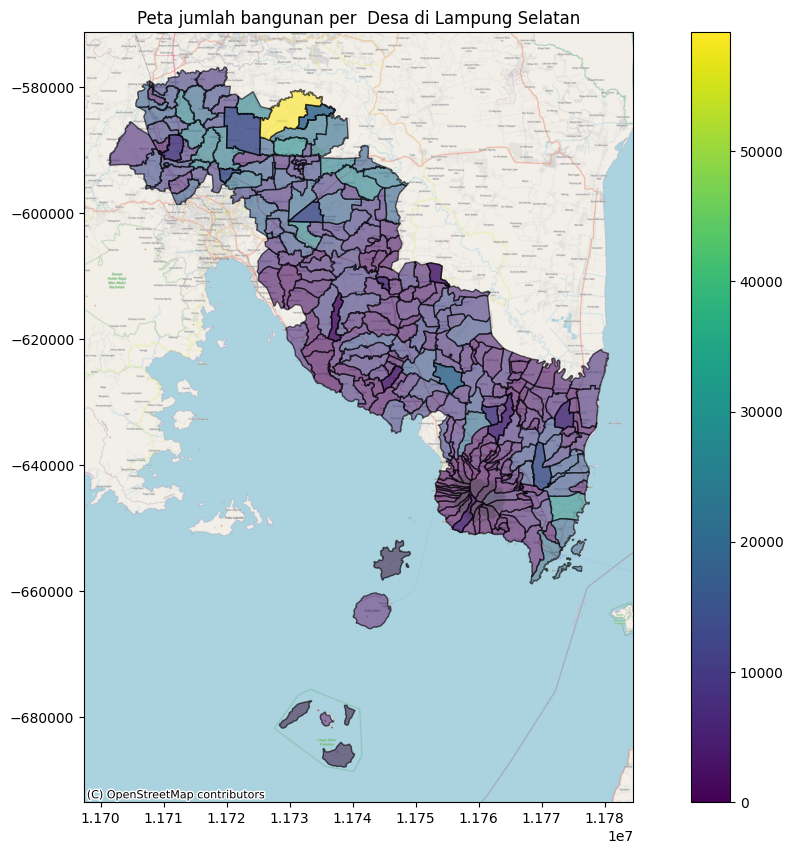

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Desa/Lamsel/SHPdesaLamsel.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.merge(datamodel, left_on='NAMOBJ', right_on='desa')
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='jumlah bangunan', ax=ax, legend=True, cmap='viridis', edgecolor='black', alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Peta jumlah bangunan per  Desa di Lampung Selatan')
plt.show()

#### Uji Hipotesis

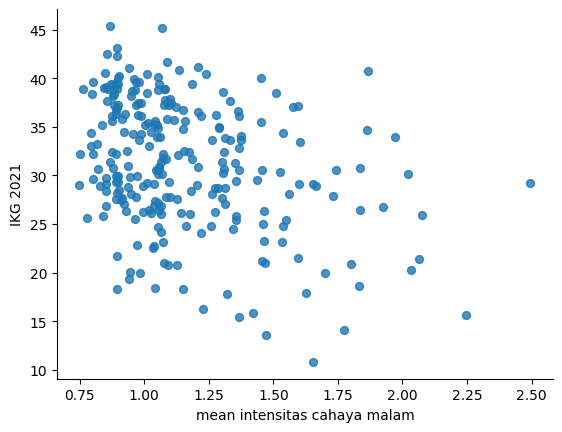

In [ ]:
from matplotlib import pyplot as plt
datamodel.plot(kind='scatter', x='mean', y='IKG 2021', s=32, alpha=.8)
plt.xlabel("mean intensitas cahaya malam")
plt.gca().spines[['top', 'right',]].set_visible(False)

Bisa terlihat hubungan IKG yang tinggi memiliki mean Intensitas rendah, terlihat dari visualisasi scatter plot, ketika nilai mean Tinggi, nilai IKG makin rendah, ketika nilai mean rendah, IKG menunjukkan nilai tinggi, sehingga bisa dikatakan saat desa memiliki mean Intensitas cahaya rendah menunjukkan desa tersebut gelap, sehingga persentse IKG nya tinggi karena infrastruktur mempengruhi IKG nya tersebut

In [ ]:
import pandas as pd
import scipy.stats as stats

p_value = stats.pearsonr(datamodel['IKG 2021'], datamodel['mean'])
print(f"P-Value: {p_value}")

# Melakukan uji hipotesis T
t_stat, t_p_value = stats.ttest_rel(datamodel['IKG 2021'], datamodel['mean'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {t_p_value}")

# Menentukan apakah menolak hipotesis nol
alpha = 0.05  # Tingkat signifikansi
if t_p_value < alpha:
    print("Keputusan:")
    print("Tolak H0: Ada hubungan negatif yang signifikan antara IKG 2021 dan Mean Intensitas Cahaya Malam")
    print("          (Ketika IKG tinggi maka rata-rata intensitas cahaya malam rendah)")
else:
    print("Keputusan:    Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Mean")
    print("Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Mean")


P-Value: PearsonRResult(statistic=-0.3457918392364866, pvalue=1.3325823482440969e-08)
T-Statistic: 71.4864365419667
P-Value: 1.0453479438195706e-170
Keputusan:
Tolak H0: Ada hubungan negatif yang signifikan antara IKG 2021 dan Mean Intensitas Cahaya Malam
          (Ketika IKG tinggi maka rata-rata intensitas cahaya malam rendah)


In [ ]:
import pandas as pd
import scipy.stats as stats

p_value = stats.pearsonr(datamodel['IKG 2021'], datamodel['LUAS'])
print(f"P-Value: {p_value}")

# Melakukan uji hipotesis T
t_stat, t_p_value = stats.ttest_rel(datamodel['IKG 2021'], datamodel['LUAS'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {t_p_value}")

# Menentukan apakah menolak hipotesis nol
alpha = 0.05  # Tingkat signifikansi
if t_p_value < alpha:
    print("Keputusan:")
    print("Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan Luas desa")
else:
    print("Keputusan:    Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Luas desa")
    print("Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Luas desa")

P-Value: PearsonRResult(statistic=-0.15347896330695643, pvalue=0.013962460639825704)
T-Statistic: -20.40027950928144
P-Value: 1.6353255737160307e-55
Keputusan:
Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan Luas desa


In [ ]:
import pandas as pd
import scipy.stats as stats
datamodel['ketinggian(m)']= datamodel['ketinggian(m)'].fillna(datamodel['ketinggian(m)'].mean())
p_value = stats.pearsonr(datamodel['IKG 2021'], datamodel['ketinggian(m)'])
print(f"P-Value: {p_value}")

# Melakukan uji hipotesis T
t_stat, t_p_value = stats.ttest_rel(datamodel['IKG 2021'], datamodel['ketinggian(m)'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {t_p_value}")

# Menentukan apakah menolak hipotesis nol
alpha = 0.05  # Tingkat signifikansi
if t_p_value < alpha:
    print("Keputusan:")
    print("Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan Ketinggian desa")
else:
    print("Keputusan:    Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Ketinggian desa")
    print("Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan Ketinggian desa")

P-Value: PearsonRResult(statistic=0.10557696107794622, pvalue=0.09185767461299331)
T-Statistic: -9.152507454062016
P-Value: 1.8531461206985798e-17
Keputusan:
Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan Ketinggian desa


In [ ]:
import pandas as pd
import scipy.stats as stats
datamodel['ketinggian(m)']= datamodel['ketinggian(m)'].fillna(datamodel['jumlah bangunan'].mean())
p_value = stats.pearsonr(datamodel['IKG 2021'], datamodel['ketinggian(m)'])
print(f"P-Value: {p_value}")

# Melakukan uji hipotesis T
t_stat, t_p_value = stats.ttest_rel(datamodel['IKG 2021'], datamodel['jumlah bangunan'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {t_p_value}")

# Menentukan apakah menolak hipotesis nol
alpha = 0.05  # Tingkat signifikansi
if t_p_value < alpha:
    print("Keputusan:")
    print("Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan jumlah bangunan")
else:
    print("Keputusan:    Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan jumlah bangunan")
    print("Terima H0: Tidak ada hubungan yang signifikan antara IKG 2021 dan jumlah bangunan")

P-Value: PearsonRResult(statistic=0.10557696107794622, pvalue=0.09185767461299331)
T-Statistic: -17.149839614022227
P-Value: 2.2854055020060917e-44
Keputusan:
Tolak H0: Ada hubungan yang signifikan antara IKG 2021 dan jumlah bangunan


# Model & Evaluasi Model

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load your data[]

x = datamodel[['mean','LUAS','jumlah bangunan','ketinggian(m)']]
y = datamodel['IKG 2021']
desa = datamodel['desa']

# Handle missing values
imputer = SimpleImputer(strategy='median')
x = imputer.fit_transform(x)

# Handle outliers
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X= scaler.fit_transform(x)


# Split data
X_train, X_test, y_train, y_test, desa_train, desa_test = train_test_split(X, y, desa, test_size=0.3, random_state=50)

# Define multiple models
models = [
    ('MLPRegressor', MLPRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('LinearRegression', LinearRegression()),
    ('SVR', SVR()),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
    ('XGBRegressor', XGBRegressor())
]

# Hyperparameter tuning (contoh untuk Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf = RandomForestRegressor(**best_params)

# Evaluate models
results = []
for name, model in models:
    if name == 'RandomForestRegressor':
        model = best_rf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append((name, mse, mae, r2, rmse))

# Print results
for name, mse, mae, r2, rmse in results:
    print(f'\n**Model: {name}**')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    print(f'Root Mean Squared Error: {rmse}')

# Choose the best model and generate predictions
best_model = min(results, key=lambda x: x[1])  # Pilih model dengan MSE terendah
print(f'\nBest model: {best_model[0]}')

best_model = models[results.index(best_model)][1]
y_pred = best_model.predict(X_test)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'desa': desa_test, 'Actual': y_test, 'Predicted': y_pred})

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



**Model: MLPRegressor**
Mean Squared Error: 543.2840707147359
Mean Absolute Error: 22.104852910520286
R-squared: -10.906739612319322
Root Mean Squared Error: 23.308454919078955

**Model: RandomForestRegressor**
Mean Squared Error: 41.91206686639659
Mean Absolute Error: 5.230074692407863
R-squared: 0.08144542847395353
Root Mean Squared Error: 6.4739529552196

**Model: LinearRegression**
Mean Squared Error: 39.54556343509316
Mean Absolute Error: 5.26817668021583
R-squared: 0.13331026616580888
Root Mean Squared Error: 6.288526332543512

**Model: SVR**
Mean Squared Error: 35.18070837669453
Mean Absolute Error: 4.810459097377241
R-squared: 0.2289714412808731
Root Mean Squared Error: 5.931332765634932

**Model: KNeighborsRegressor**
Mean Squared Error: 40.986355065369956
Mean Absolute Error: 4.959257963819425
R-squared: 0.10173354286017999
Root Mean Squared Error: 6.402058658382471

**Model: DecisionTreeRegressor**
Mean Squared Error: 77.98315716633789
Mean Absolute Error: 6.839282278431449

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load your data[]
x = datamodel[['mean','LUAS','jumlah bangunan','ketinggian(m)']]
y = datamodel['IKG 2021']
desa = datamodel['desa']

# Handle missing values
imputer = SimpleImputer(strategy='median')
x = imputer.fit_transform(x)

# Handle outliers
#scaler = StandardScaler()
#X = scaler.fit_transform(x)

# Handle outliers
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X= scaler.fit_transform(x)


# Split data
X_train, X_test, y_train, y_test, desa_train, desa_test = train_test_split(X, y, desa, test_size=0.3, random_state=50)

# Define multiple models
models = [
    ('SVR Kernel Linear', SVR(kernel='linear')),
    ('SVR Kernel RBF', SVR(kernel='rbf')),
    ('SVR Kernel Sigmoid', SVR(kernel='sigmoid')),
    ('SVR Kernel Polynomial', SVR(kernel='poly'))
]

# Hyperparameter tuning (contoh untuk Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf = RandomForestRegressor(**best_params)

# Evaluate models
results = []
for name, model in models:
    if name == 'RandomForestRegressor':
        model = best_rf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append((name, mse, mae, r2, rmse))

# Print results
for name, mse, mae, r2, rmse in results:
    print(f'\n**Model: {name}**')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    print(f'Root Mean Squared Error: {rmse}')

# Choose the best model and generate predictions
best_model = min(results, key=lambda x: x[1])  # Pilih model dengan MSE terendah
print(f'\nBest model: {best_model[0]}')

best_model = models[results.index(best_model)][1]
y_pred = best_model.predict(X_test)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'desa': desa_test, 'Actual': y_test, 'Predicted': y_pred})


**Model: SVR Kernel Linear**
Mean Squared Error: 40.444088893714266
Mean Absolute Error: 5.204170073023569
R-squared: 0.11361797396079987
Root Mean Squared Error: 6.3595667221686

**Model: SVR Kernel RBF**
Mean Squared Error: 35.18070837669453
Mean Absolute Error: 4.810459097377241
R-squared: 0.2289714412808731
Root Mean Squared Error: 5.931332765634932

**Model: SVR Kernel Sigmoid**
Mean Squared Error: 63.989117806565375
Mean Absolute Error: 6.147133996921219
R-squared: -0.4024003367933351
Root Mean Squared Error: 7.999319833996224

**Model: SVR Kernel Polynomial**
Mean Squared Error: 131.8079415533152
Mean Absolute Error: 6.128164312004034
R-squared: -1.8887333965938797
Root Mean Squared Error: 11.480763979514395

Best model: SVR Kernel RBF


In [ ]:
predictions

,desa,Actual,Predicted
226,Tanjung Baru,20.005083,29.558778
254,Way Muli,29.982782,34.076736
82,Kelawi,20.990842,31.152567
160,Ruguk,30.836709,29.274833
88,Klaten,33.903126,30.137894
...,...,...,...
198,Sukabakti,39.456175,32.099530
54,Gunung Terang,24.674148,33.052087
238,Tetaan,39.379381,29.497648
41,Candi Mas,23.161170,27.789835


from matplotlib import pyplot as plt
predictions['Actual'].plot(kind='hist', bins=20, title='Actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions['Predicted'].plot(kind='hist', bins=20, title='Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions['Actual'].plot(kind='line', figsize=(8, 4), title='Actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
predictions['Predicted'].plot(kind='line', figsize=(8, 4), title='Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

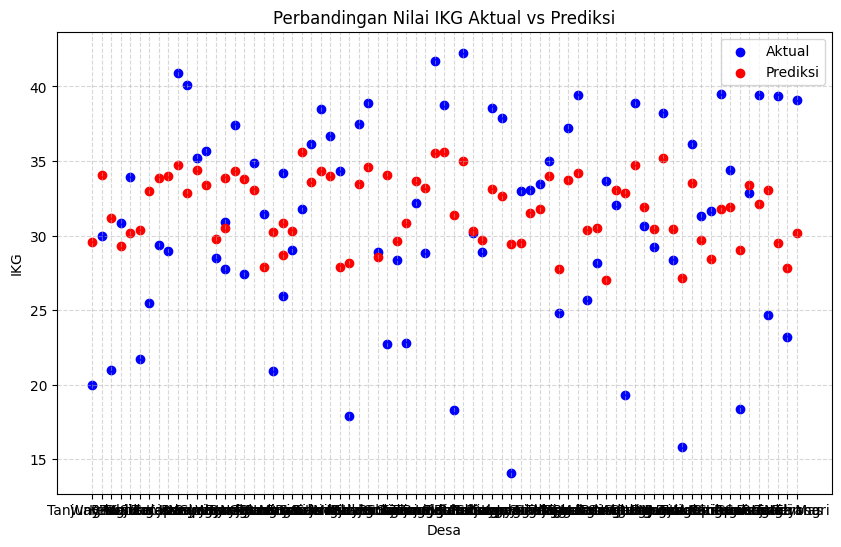

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(predictions['desa'], predictions['Actual'], color='blue', label='Aktual')
plt.scatter(predictions['desa'], predictions['Predicted'], color='red', label='Prediksi')
plt.title('Perbandingan Nilai IKG Aktual vs Prediksi')
plt.xlabel('Desa')
plt.ylabel('IKG')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

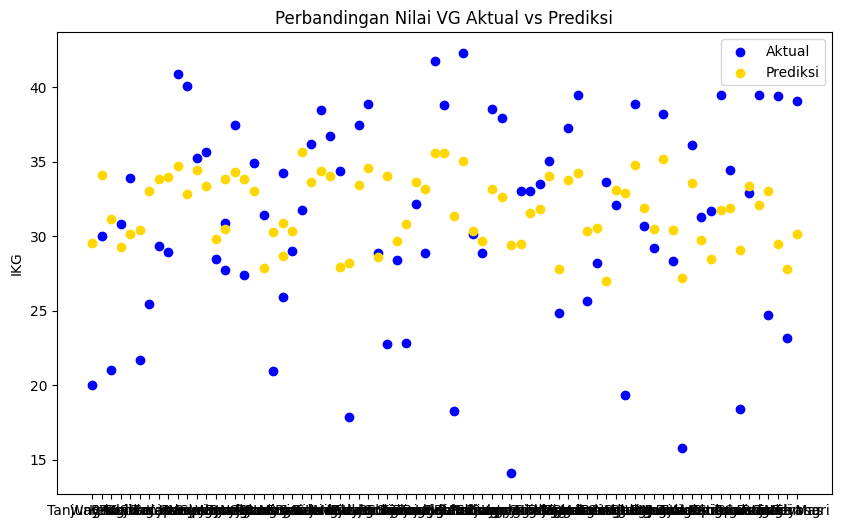

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumsikan data Anda berada dalam DataFrame bernama 'data'
# dengan kolom 'desa', 'vg', dan 'fgh'

# Membuat scatterplot
plt.figure(figsize=(10, 6))

# Titik data aktual (biru)
plt.scatter(predictions['desa'], predictions['Actual'], color='blue', label='Aktual')

# Titik data prediksi (emas)
plt.scatter(predictions['desa'], predictions['Predicted'], color='gold', label='Prediksi')

# Memberi judul dan label sumbu
plt.title('Perbandingan Nilai VG Aktual vs Prediksi')
plt.ylabel('IKG')

# Menampilkan legend
plt.legend()

# Menampilkan plot
plt.show()

In [ ]:
predictions.to_excel('prelllll.3.xlsx' , index=False, header=True)

In [ ]:
from scipy.stats import pearsonr

#correlation, _ = pearsonr(y_test, y_pred)
correlation, _ = pearsonr(predictions['Actual'], predictions['Predicted'])

print(f'Korelasi Pearson pada model yang dibangun: {correlation}')
if 0.80 <= correlation <= 1.00:
    print("Korelasi sangat kuat")
elif 0.60 <= correlation <= 0.799:
    print("Korelasi kuat")
elif 0.40 <= correlation <= 0.599:
    print("Korelasi sedang (moderat)")
elif 0.20 <= correlation <= 0.399:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.199:
    print("Korelasinya sangat lemah")

Korelasi Pearson pada model yang dibangun: 0.5187436142281988
Korelasi sedang (moderat)
